In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm 
import intake
import fsspec
import seaborn as sns
import math
import cartopy.crs as ccrs
import cartopy.feature as cf
import os
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

<ipython-input-1-caab388ed498>:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims,skipna=True)

def alaska_mean(ds):
    lat_slice = ds.sel(lat=slice(55,75))
    ak_slice = lat_slice.sel(lon=slice(188,255))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims,skipna=True)

def ne_america_mean(ds):
    lat_slice = ds.sel(lat=slice(30,45))
    ak_slice = lat_slice.sel(lon=slice(268,288))
    lat = ak_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ak_slice.dims) - {'time'}
    return (ak_slice * weight).mean(other_dims,skipna=True)

def arctic_mean(ds):
    lat_slice = ds.sel(lat=slice(60,90))
    lat = lat_slice[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(lat_slice.dims) - {'time'}
    return (lat_slice * weight).mean(other_dims,skipna=True)

In [ ]:
def load_all_models(model_name):
    tas_anomaly_hist = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_historical.nc')
    #tas_anomaly_ssp126 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp126.nc')
    tas_anomaly_ssp245 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp245.nc')
    #tas_anomaly_ssp370 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp370.nc')
    tas_anomaly_ssp585 = xr.open_dataset('/nobackup/users/lulur/tas-anomaly_'+model_name+'_ssp585.nc')
    tas_anomalies = [tas_anomaly_hist,tas_anomaly_ssp245,tas_anomaly_ssp585]
    return tas_anomalies

In [ ]:
def calc_anomalies(source_ids):
    """
    Calculates the surface temperature anomalies for various regions, returns a list of datasets
    each dataset is for 1 scenario and contains the mean temperature anomaly for 4 regions for each model source
    source_ids: a list of strings of source_ids ('ACCESS_CM2', etc)
    for 
    """
    
    regions = ['global','alaska','arctic','ne_america']
    datas = []
    for s_id in source_ids:
        datas.append(load_all_models(s_id))
        #load_all_models returns a list of datasets for each of the 3 models
        #order of models: 'historical' , 'ssp245' , 'ssp585'
    #datas is now a list of lists, one list of datsets for each source_id
    models_list = []
    for m in range(3):
        #for each scenario (hist, ssp245, etc) we create a dataset with regional means 
        source_dict = {}
        for s in range(len(source_ids)):
            model_ds = xr.Dataset(coords=dict(time=datas[s][m]['time']))
            model_ds['global_mean']=global_mean(datas[s][m])['tas']
            model_ds['alaska_mean']=alaska_mean(datas[s][m])['tas']
            model_ds['arctic_mean']=arctic_mean(datas[s][m])['tas']
            model_ds['ne_america_mean']=ne_america_mean(datas[s][m])['tas']
            source_dict[source_ids[s]]=model_ds
        models_list.append(source_dict)
    
    #we return a list of datasets, one for each scenario.
    return models_list
            
def edit_leap_years(dataset):
    """
    dataset should already have a dayofyear attribute
    determines which years are leap years and edits the dayofyear coordinate to go 1-365,
    rather than 1-366 and skipping 60
    """
    years = np.arange(1840,2300)
    leapyears = years[years%4==0]
    leapyears = leapyears[leapyears!=1900]
    leapyears = leapyears[leapyears!=2100]
    for d in range(dataset['dayofyear'].shape[0]):
        if dataset['dayofyear'][d]>60:
            if int(dataset['time.year'][d]) in leapyears:
                dataset['dayofyear'][d] -= 1
            #isleapyear = (dataset['time.year'][d]% 4 == 0) and (dataset['time.year'][d] != 1900)and (dataset['time.year'][d] != 2100)
        #if d%350 == 0:
            #print(cm2['time.year'][d]['time.year'], isleapyear)
        #if isleapyear and dataset['dayofyear'][d]>60:
            #dataset['dayofyear'][d] -= 1
    
    uniquedays_after = 0
    for d,data in dataset.groupby('dayofyear'):
        uniquedays_after +=1
    assert uniquedays_after == 365
    
    return dataset         

In [ ]:
source_id_list = ['ACCESS-CM2','ACCESS-ESM1-5','NorESM2-LM','NorESM2-MM','CanESM5','MPI-ESM1-2-HR','MPI-ESM1-2-LR']
models_list = calc_anomalies(source_id_list)

In [ ]:
models = ['historical','ssp245','ssp585']
for m in range(1,3):
    for s in source_id_list:
        print('editing leap years for ', models[m],s)
        noleapdata = edit_leap_years(models_list[m][s])
        delayed_obj = noleapdata.to_netcdf(path='/nobackup/users/lulur/region_mean_files/'+s+'_'+models[m]+'_noleap.nc', mode='w', compute=False, engine='netcdf4', format='NETCDF4')
        print('writing data to region_mean_files/'+s+'_'+models[m]+'_noleap.nc')

        with progress.ProgressBar():
            results = delayed_obj.compute()
            #print(s,models_list[2][s])

In [ ]:
cm2 = xr.open_dataset('/nobackup/users/lulur/region_mean_files/ACCESS-CM2_ssp245.nc')
uniquedays_before = 0
for d,data in cm2.groupby('dayofyear'):
    uniquedays_before +=1
print(uniquedays_before)
def edit_leap_years(dataset):
    """
    dataset should already have a dayofyear attribute
    determines which years are leap years and edits the dayofyear coordinate to go 1-365,
    rather than 1-366 and skipping 60
    """
    years = np.arange(1850,2101)
    leapyears = years[years%4==0]
    leapyears = leapyears[leapyears!=1900]
    leapyears = leapyears[leapyears!=2100]
    print(leapyears)
    for d in range(dataset['dayofyear'].shape[0]):
        if dataset['dayofyear'][d]>60:
            if int(dataset['time.year'][d]) in leapyears:
                dataset['dayofyear'][d] -= 1
            #isleapyear = (dataset['time.year'][d]% 4 == 0) and (dataset['time.year'][d] != 1900)and (dataset['time.year'][d] != 2100)
        #if d%350 == 0:
            #print(cm2['time.year'][d]['time.year'], isleapyear)
        #if isleapyear and dataset['dayofyear'][d]>60:
            #dataset['dayofyear'][d] -= 1
    
    uniquedays_after = 0
    for d,data in dataset.groupby('dayofyear'):
        uniquedays_after +=1
    print(uniquedays_after)
    assert uniquedays_after == 365
    
    return dataset 

# def edit_leap_years(dataset):
#     """
#     dataset should already have a dayofyear attribute
#     determines which years are leap years and edits the dayofyear coordinate to go 1-365,
#     rather than 1-366 and skipping 60
#     """
#     for d, ddata in dataset.groupby('time.dayofyear'):
#         if d>60:
#             years = np.asarray(ddata['time.year'],dtype=int)
#             #print(years)
#             #print('True leap years',np.sum(years% 4 == 0))
#             isleapyear = np.logical_and((years% 4 == 0),(years != 1900))
#             with_exceptions = np.logical_and((years != 2100),isleapyear)
#             #print('True leap years',np.sum(with_exceptions))#if d%350 == 0:
#                 #print(cm2['time.year'][d]['time.year'], isleapyear)
#             days = np.asarray(ddata['dayofyear'],dtype=int)
#             #print(type(days[0]),type(with_exceptions[0]),days.shape,with_exceptions.shape)
#             days[with_exceptions] = d-1
#             ddata['dayofyear'] = days

#     uniquedays_after = 0
#     for d,data in dataset.groupby('dayofyear'):
#         uniquedays_after +=1
#     print(uniquedays_after)
#     #assert uniquedays_after == 365
    
#     return dataset

new_cm2 = edit_leap_years(cm2)
new_cm2['dayofyear'].where(new_cm2['dayofyear']==366,drop=True).shape

In [14]:
#calculate the mean and standard deviation of surface temperatures for each region over the historical period
def find_std_mean(source_id):
    dataset = xr.open_dataset('/nobackup/users/lulur/region_mean_files/'+source_id+'_historical_noleap.nc')
    slice_mst = dataset.sel(time=slice('1981-01-01', '2010-12-31'))
    means = []
    stds = []
    days = []
    for doy, doydata in slice_mst.groupby('dayofyear'):
        #for day, data in mdata.groupby('time.day'):
        meantemp = doydata.mean('time')
        stdtemp = doydata.std('time')
        means.append(meantemp)
        days.append(doy)
        stdtemp['dayofyear']=doy
        stds.append(stdtemp)
    #means.append(region_means)
    #stds.append(region_stds)
    #print(days)
    stds_concat = xr.concat(stds,'dayofyear')
    return stds_concat
        

In [15]:
print(find_std_mean('ACCESS-CM2')['dayofyear']

<xarray.Dataset>
Dimensions:          (dayofyear: 365)
Coordinates:
    height           float64 2.0
  * dayofyear        (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    global_mean      (dayofyear) float64 0.2509 0.2668 0.2716 ... 0.2644 0.276
    alaska_mean      (dayofyear) float64 3.776 3.752 4.173 ... 4.173 4.234 4.016
    arctic_mean      (dayofyear) float64 1.885 1.88 1.908 ... 1.808 1.824 1.762
    ne_america_mean  (dayofyear) float64 4.311 4.82 4.727 ... 4.655 4.018 3.845

In [29]:
models = ['historical','ssp245','ssp585']
source_id_list = ['ACCESS-CM2','ACCESS-ESM1-5','NorESM2-LM','NorESM2-MM','CanESM5','MPI-ESM1-2-HR','MPI-ESM1-2-LR']

source_std_dict = {}
for s in range(len(source_id_list)):
    source_std_dict[source_id_list[s]]= find_std_mean(source_id_list[s])

scenarios_dict = {}
for m in models:
    source_dict = {}
    for s in source_id_list:
        dataset = xr.open_dataset('/nobackup/users/lulur/region_mean_files/'+s+'_'+m+'_noleap.nc')
        source_dict[s] = dataset
    scenarios_dict[m]= source_dict

/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/home/lulur/.conda/envs/cicoes39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [21]:
#scenarios_dict['ssp245']['ACCESS-CM2']
source_std_dict['ACCESS-CM2']

<xarray.Dataset>
Dimensions:          (dayofyear: 365)
Coordinates:
    height           float64 2.0
  * dayofyear        (dayofyear) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    global_mean      (dayofyear) float64 0.2509 0.2668 0.2716 ... 0.2644 0.276
    alaska_mean      (dayofyear) float64 3.776 3.752 4.173 ... 4.173 4.234 4.016
    arctic_mean      (dayofyear) float64 1.885 1.88 1.908 ... 1.808 1.824 1.762
    ne_america_mean  (dayofyear) float64 4.311 4.82 4.727 ... 4.655 4.018 3.845

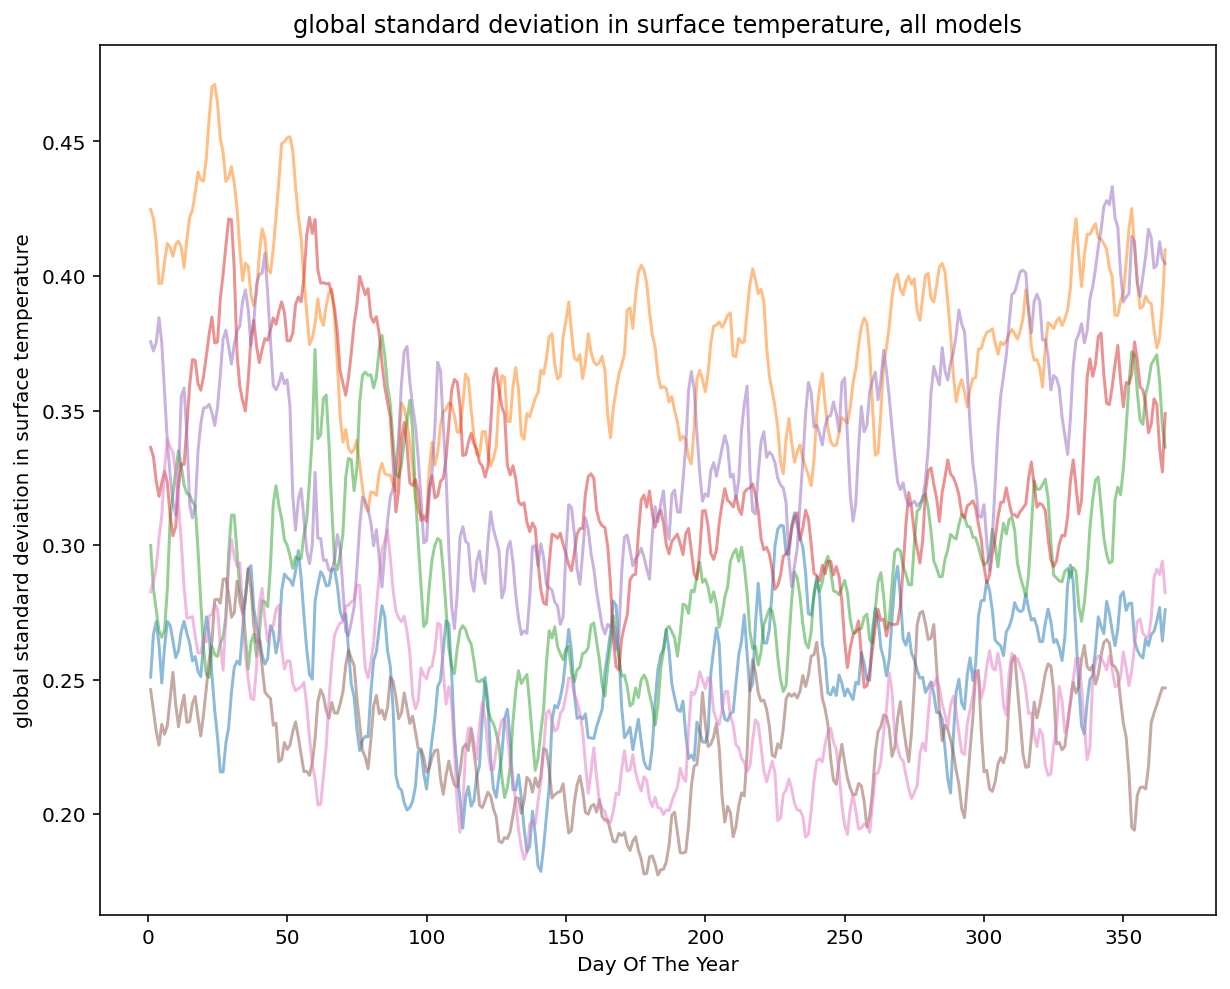

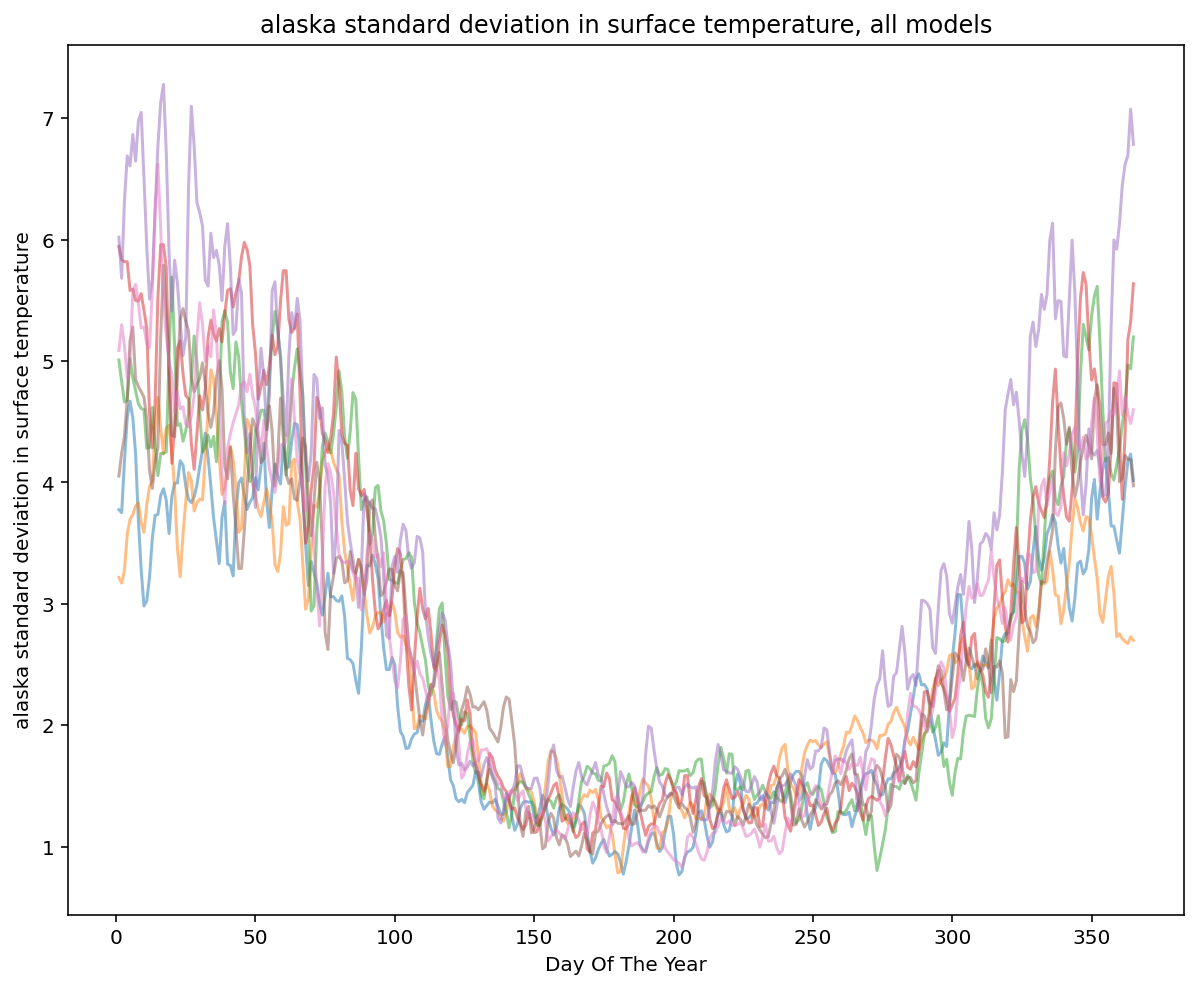

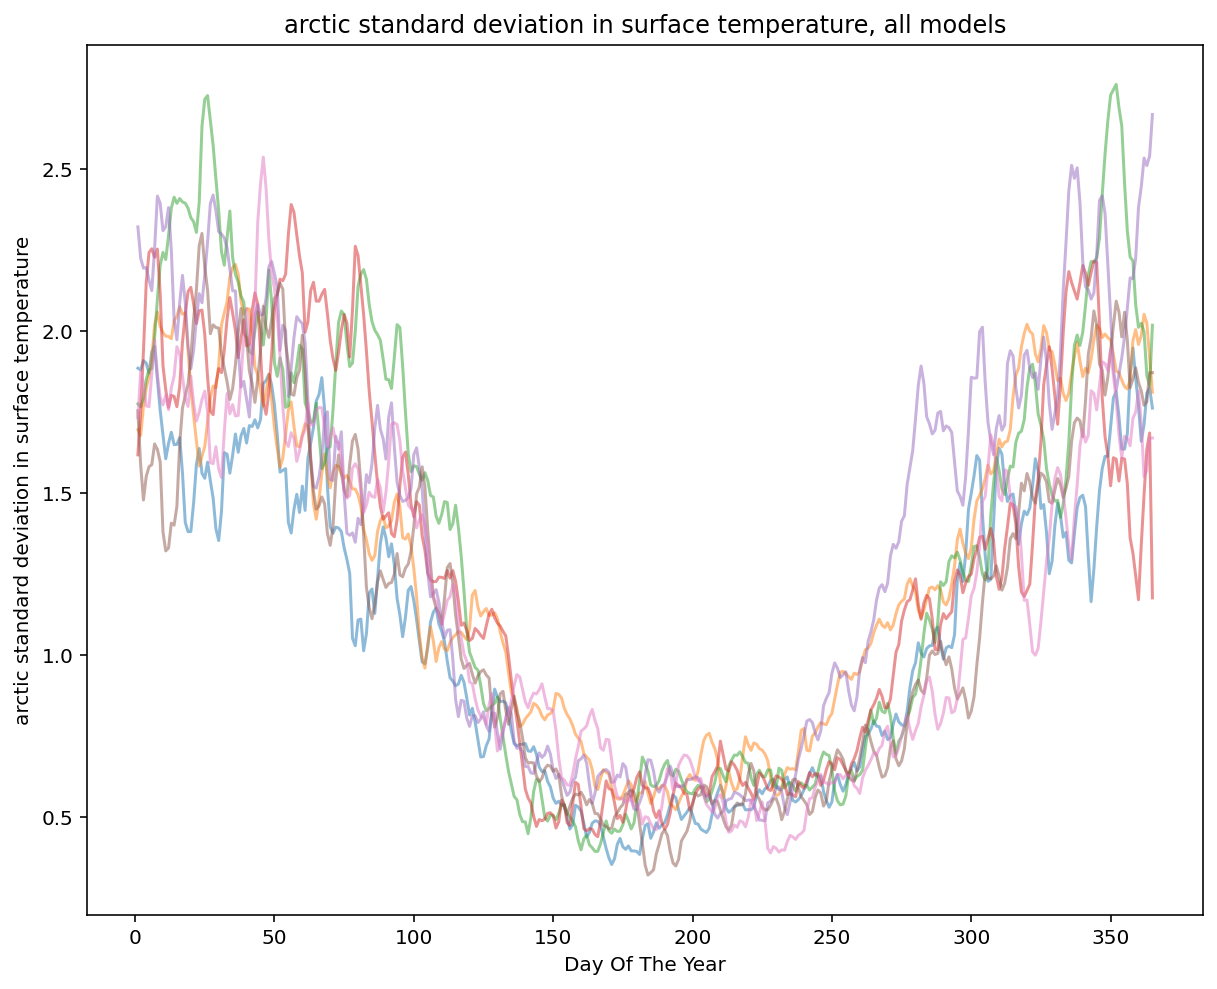

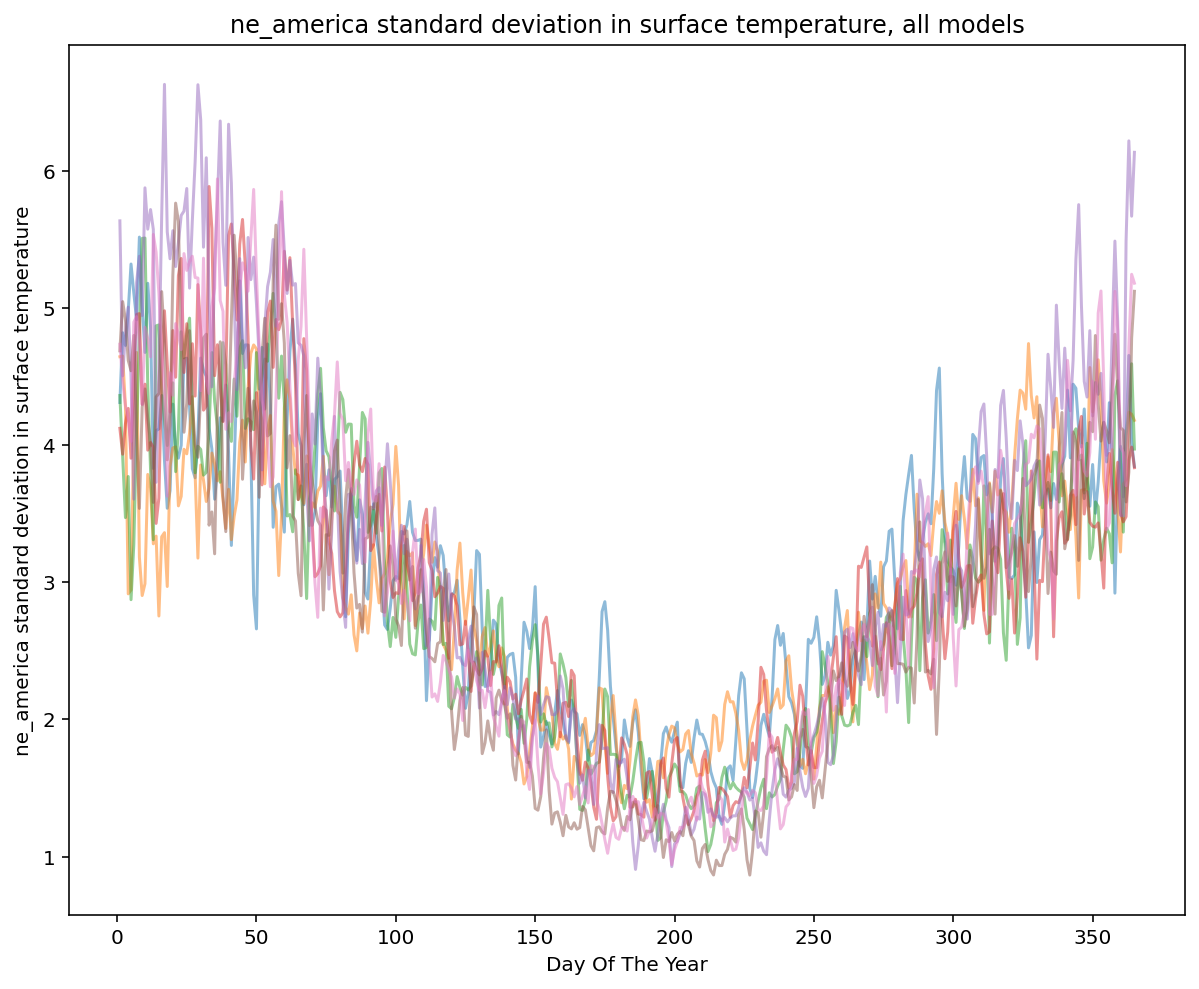

In [35]:
for r in regions:
    plt.figure(figsize=(10,8))
    for s in source_id_list:
        stdev = source_std_dict[s]
        #timeslice = data_arrs[i].sel(time=slice('1989-01-01', '1995-12-31'))
        #timeslice = np.asarray(histdata['time'])
        #time = [i[0].dayofyear for i in data_arrs[i]['time']]
        plt.plot(np.arange(1,366),stdev[r+'_mean'],alpha=0.5)
        #plt.plot(clims[i]['time'].dt.dayofyear,clims[i],label = regions[i]+' climatology mean')
        #plt.xlim(1990,2000)
        #plt.legend()
    plt.title(r+' standard deviation in surface temperature, all models')
    plt.xlabel('Day Of The Year')
    plt.ylabel(r+' standard deviation in surface temperature')
    plt.savefig('./figures//climatology_stdevs' + regions[i]+'.png')

In [31]:
#Calculate the number of standard deviations from mean for every day in the dataset
regions = ['global','alaska','arctic','ne_america']
def calc_std_anomalies(source_id,model_name):
    regions = ['global','alaska','arctic','ne_america']
    stdevs = source_std_dict[source_id]
    anomaly_data = scenarios_dict[model_name][source_id].copy()
    #rename_dict = {'global_mean':'global_std','alaska_mean':'alaska_std','arctic_mean':'arctic_std','ne_america_mean':'ne_america_std'}
    #stdevs = stdevs.rename(rename_dict)
    #anomaly_data
    for r in regions:
        anomaly_data[r+'_anomaly_std'] = anomaly_data[r+'_mean'].groupby('dayofyear')-stdevs[r+'_mean']#.groupby('dayofyear')
    return anomaly_data
        

scenarios_stdevs = {}
for m in models:
    source_stdevs = {}
    for s in source_id_list: 
        dataset = calc_std_anomalies(s,m)
        source_stdevs[s] = dataset
    scenarios_stdevs[m]= source_stdevs

# ACCESS_CM2_stdata = calc_std_anomalies('ACCESS-CM2','ssp245')
# ACCESS_CM2_stdata
# hist_stdevs = []
# for r in range(4):
#     region_temp_stdev = []
#     years = []
#     print('calculating for region ',regions[r])
#     for year, ydata in msts[r].groupby('time.year'):
#         for month, mdata in ydata.groupby('time.month'):
#             for day, data in mdata.groupby('time.day'):
#                 index = monthday.index((month,day))
#                 stdev = stds[r][index]
#                 n_stdev = float(data['anomalies'])/stdev
#                 region_temp_stdev.append(n_stdev)
#                 years.append(year)
#     hist_stdevs.append(region_temp_stdev)

In [32]:
scenarios_stdevs['ssp245']['ACCESS-CM2']


<xarray.Dataset>
Dimensions:                 (time: 31411)
Coordinates:
    height                  float64 ...
    dayofyear               (time) int64 1 2 3 4 5 6 ... 360 361 362 363 364 365
  * time                    (time) datetime64[ns] 2015-01-01T12:00:00 ... 210...
Data variables:
    global_mean             (time) float64 ...
    alaska_mean             (time) float64 ...
    arctic_mean             (time) float64 ...
    ne_america_mean         (time) float64 ...
    global_anomaly_std      (time) float64 0.3988 0.3144 0.299 ... 3.396 3.315
    alaska_anomaly_std      (time) float64 -3.719 -5.292 -7.914 ... 4.675 4.672
    arctic_anomaly_std      (time) float64 0.7176 -0.03943 ... 10.34 10.64
    ne_america_anomaly_std  (time) float64 -12.68 -12.72 -8.583 ... 4.322 0.5017

In [ ]:
def plot_

In [ ]:
def plot_daily_anomaly_by_year(year,msts):
    plt.figure(figsize=(8,6))
    if year < 2015:
        slicem = msts[0].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
        plt.plot(slicem['time'],slicem['tas'],label=models[0])
    else:
        for i in range(1,len(msts)):
            slicem = msts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
            plt.plot(slicem['time'],slicem['tas'],label=models[i])
        #plt.xlim(19
    #plt.ylim(0)
    plt.title('Modelled Daily Temperature Anomaly in Alaska, '+str(year))
    #plt.legend()
    plt.show()
    plt.savefig('./figures/daily_anomalies/dailyanomaly_alaska_'+str(year)+'.png')

years = (2020,2030,2040,2050)
hist_years = (1985,1995,2000,2005,2010)
for yr in hist_years:
    plot_daily_anomaly_by_year(yr,akmsts)

In [ ]:
def plot_daily_anomaly_by_year(year,msts):
    plt.figure(figsize=(8,6))
    if year < 2015:
        slicem = msts[0].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
        plt.plot(slicem['time'],slicem['tas'],label=models[0])
    else:
        for i in range(1,len(msts)):
            slicem = msts[i].sel(time=slice(str(year)+'-01-01', str(year)+'-12-31'))
            plt.plot(slicem['time'],slicem['tas'],label=models[i])
        #plt.xlim(19
    #plt.ylim(0)
    plt.title('Modelled Daily Temperature Anomaly in the Arctic, '+str(year))
    #plt.legend()
    plt.show()
    plt.savefig('./figures/daily_anomalies/dailyanomaly_arctic_'+str(year)+'.png')

#years = (2020,2030,2040,2050)
hist_years = (1985,1995,2000,2005,2010)
for yr in hist_years:
    plot_daily_anomaly_by_year(yr,arcmsts)

In [ ]:
arcmsts[0]['time.year'].shape

In [ ]:
plt.contourf([dailymax['latitude'],dailymax['longitude'],],dailymax['mx2t'])